## 导入需要的库

In [15]:
import sys
import numpy as np
sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod")

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from MatchedFilter import matched_filter as mf
from MatchedFilter import generate_uas as gu
from MyFunctions import needed_function as nf
from MyFunctions import radiance_lut as rl


## 必要的函数



In [16]:
def profile_matched_filter(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum
    concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 
    return concentration[0]


def profile_matched_filter_ML(base_array, data_array: np.array,unit_absorption_spectrum: np.array) :
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 

    if concentration[0] > 4000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[1]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 4000
    if concentration[0] > 8000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[2]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 8000
    if concentration[0] > 12000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[3]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 12000
    if concentration[0] > 16000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[4]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 16000
    if concentration[0] > 20000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[5]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 20000
    if concentration[0] > 24000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[6]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 24000
    if concentration[0] > 28000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[7]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 28000
    if concentration[0] > 32000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[8]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + 32000
    
    
    return concentration[0]


def matched_filter_with_fixed_bg(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands,rows,cols = data_array.shape
    concentration = np.zeros((rows,cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    # fig,ax = plt.subplots(1,2)
    # for i in range(rows):
    #     for j in range(cols):
    #         ax[0].plot(radiancediff_with_back[:,i,j],label="radiance",color='red')
    # ax[1].plot(target_spectrum,label="background")
    # plt.show()
    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands,bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:,i,j], d_covariance[:,i,j])
    covariance /= rows*cols
    covariance_inverse = np.linalg.inv(covariance)
    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i,j] = up / down
    
    return concentration


def modified_matched_filter_with_fixed_bg(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands,rows,cols = data_array.shape
    concentration = np.zeros((rows,cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    
    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands,bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:,i,j], d_covariance[:,i,j])
    covariance /= rows*cols
    covariance_inverse = np.linalg.inv(covariance)
    
    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i,j] = up / down
            
    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[1]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 4000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 4000
    
    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[2]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 8000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 8000
    
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[3]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 12000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 12000
    
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[4]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 16000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 16000
    
    return concentration


def image_simulation(plume, lower_wavelength, upper_wavelength, row_num, col_num,noise_level):
    # Load the simulated emit radiance spectrum
    total_bands,lut = rl.load_lookup_table("C:\\Users\\RS\\VSCode\matchedfiltermethod\\MyData\\enhanced_radiance\\AHSI_rad_lookup_table.npz")
    
    bands,unenhanced_radiance = rl.lookup_spectrum(0,total_bands,lut,lower_wavelength,upper_wavelength)
    # Set the shape of the image that want to simulate
    band_num = len(bands)
    simulated_image = np.zeros([band_num, row_num, col_num])
    # Generate the universal radiance cube image
    for i in range(row_num) :
        for j in range(col_num) :
            if plume[i,j] > 0:
                _,enhanced_radiance = rl.lookup_spectrum(plume[i,j],total_bands,lut,lower_wavelength,upper_wavelength)
                simulated_image[:,i,j] = enhanced_radiance
            else:
                simulated_image[:,i,j] = unenhanced_radiance
    # 为每个波段添加 1% 的高斯噪声
    noise_std = 0.01 * simulated_image  # 噪声的标准差为辐亮度的 1%
    noise = np.random.normal(0, noise_std)
    simulated_noisy_image = simulated_image + noise 
  
    return simulated_noisy_image


def twoperc_enhancement(enhancement):
    np.random.seed(42)  
    matrix_size = 100
    indices = np.random.choice(matrix_size * matrix_size, 200, replace=False)
    plume = np.zeros((matrix_size, matrix_size))
    np.put(plume, indices, enhancement)
    
    # 选取剩余的像素点作为未增强的像素点,并将选取的像素点转换为行列索引，分别是增强和未增强的像素点
    all_indices = np.arange(plume.size)
    unenhanced_indices = np.setdiff1d(all_indices, indices)
    enhanced_mask = np.unravel_index(indices, (matrix_size, matrix_size))
    unenhanced_mask = np.unravel_index(unenhanced_indices, (matrix_size, matrix_size))
    
    # 生成模拟影像
    simulated_image = image_simulation(plume,2150, 2500, 100, 100, 0.01)
    return simulated_image,enhanced_mask,unenhanced_mask


def polyfit_plot(enhancements,resultlist,ax,labelstr):
    slope,intercept = np.polyfit(enhancements,resultlist,1)
    x_fit = np.linspace(min(enhancements), max(enhancements), 100)
    y_fit = slope * x_fit + intercept
    if intercept > 0 :
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x + {np.abs(intercept):.2f}' )
    elif intercept < 0 :
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x - {np.abs(intercept):.2f}' )
    else:
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x' )


## 光谱测试
模拟的具备甲烷浓度增强的卫星光谱的匹配滤波拟合浓度增强

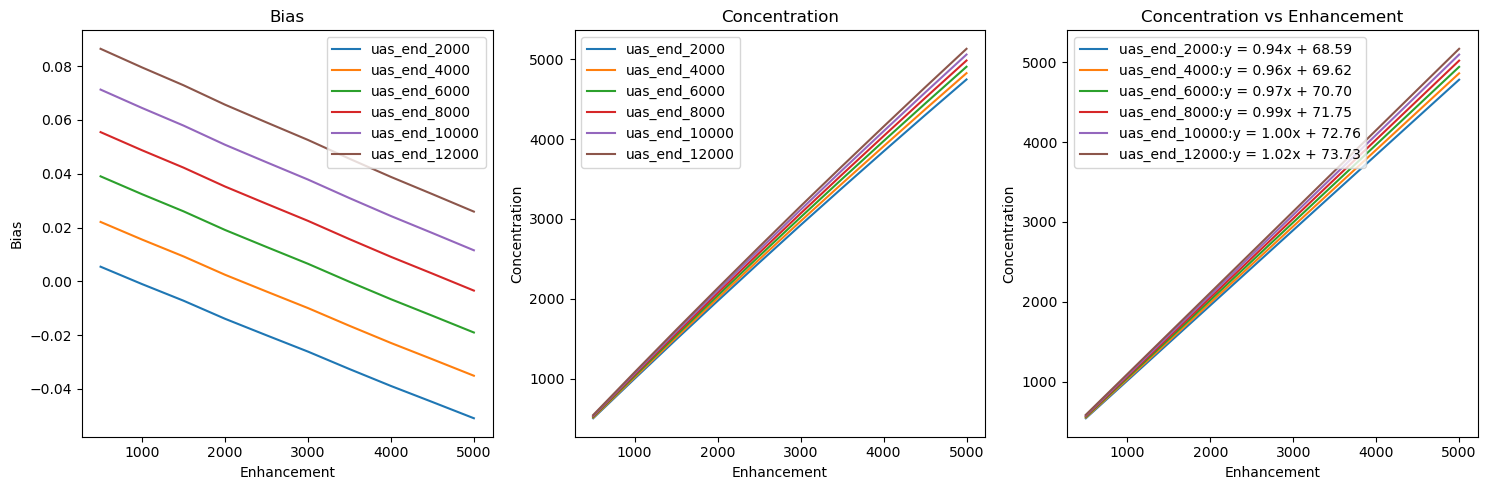

In [35]:
def spectrumlevel_test1():
    """
    测试不同浓度增强下的甲烷廓线直接拟合的浓度结果。 
    使用拟合区间不同的单位吸收光谱。
    """
   
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    for end in range(2000,14000,2000):
        # 读取单位吸收光谱 UAS
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{end}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        
        # 初始化变量
        base = None
        channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        _,base = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
        concentration = 0
        concentrationlist = []
        biaslists = []

        # 拟合甲烷浓度增强
        enhancements = np.arange(500,5500,500)
        for enhancement in enhancements:
            # 读取模拟辐射数据
            filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{int(enhancement)}_ppmm_tape7.txt"
            _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
            # 通过直接拟合的方法计算甲烷浓度增强，并计算与实际值的偏差
            concentration = profile_matched_filter(base,radiance,uas)
            biaslists.append(((concentration-enhancement)/enhancement))
            concentrationlist.append(concentration)

        ax[0].plot(enhancements,biaslists,label=f"uas_end_{end}")
        ax[1].plot(enhancements,concentrationlist,label=f"uas_end_{end}")
        polyfit_plot(enhancements,concentrationlist,ax[2],f"uas_end_{end}")
 
    ax[0].set_title("Bias")
    ax[0].set_xlabel("Enhancement")
    ax[0].set_ylabel("Bias")
    ax[0].legend()
    
    ax[1].set_title("Concentration")
    ax[1].set_xlabel("Enhancement")
    ax[1].set_ylabel("Concentration")
    ax[1].legend()
    
    ax[2].set_title("Concentration vs Enhancement")
    ax[2].set_xlabel("Enhancement")
    ax[2].set_ylabel("Concentration")
    ax[2].legend()
    plt.tight_layout()
    plt.show()
    
    return biaslists

biaslist = spectrumlevel_test1()


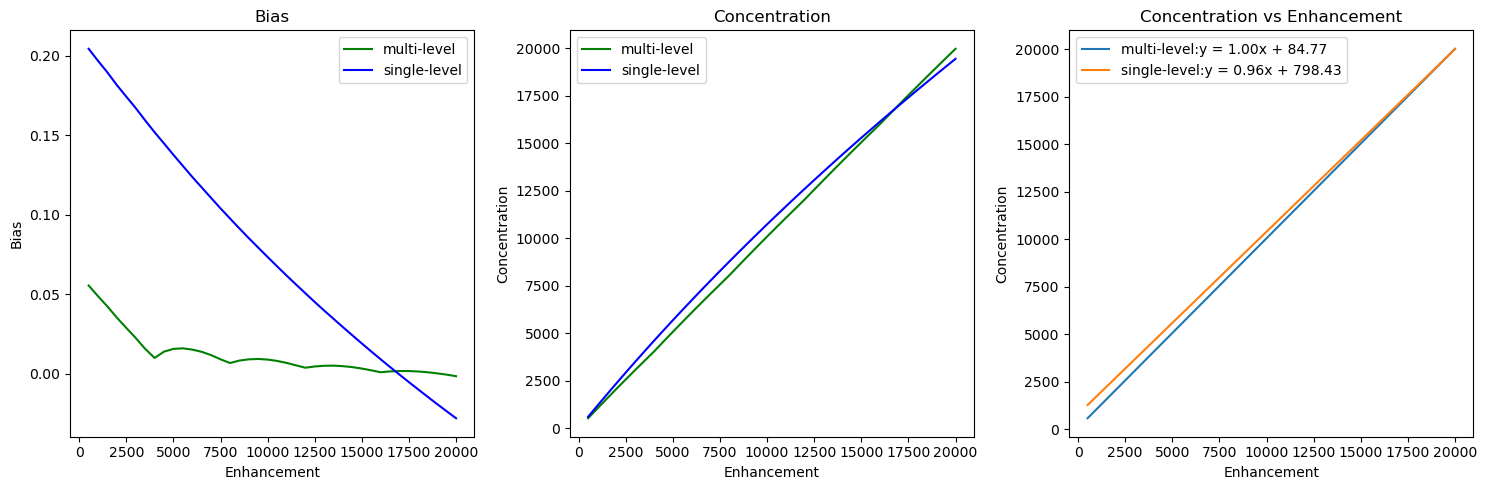

In [54]:
def spectrumlevel_test2():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """
    # 读取单位吸收光谱    
    ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_30000.txt"
    _,base_uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
    
    # 读取多级单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(8000,46000,8000)
    for i in uasrange:
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        uaslist.append(uas)
    
    # 读取背景光谱
    channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    _,base_radiance = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
    
    # initiatate variables
    ml_concentrationlist = []
    ml_biaslists = []
    sg_concentrationlist = []
    sg_biaslists = []
    
    # 拟合甲烷浓度增强
    enhancements = np.arange(500,20500,500)
    for enhancement in enhancements:
        # 读取模拟辐射数据
        filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{enhancement}_ppmm_tape7.txt"
        _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
    
        # 计算甲烷浓度增强，并计算与实际值的偏差
        concentration = profile_matched_filter_ML(base_radiance,radiance,uaslist)
        ml_biaslists.append(((concentration-enhancement)/enhancement))
        ml_concentrationlist.append(concentration)
        
        concentration = profile_matched_filter(base_radiance,radiance,base_uas)
        sg_biaslists.append(((concentration-enhancement)/enhancement))
        sg_concentrationlist.append(concentration)
        
    # 可视化
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].plot(enhancements,ml_biaslists,color="green",label="multi-level")
    ax[0].plot(enhancements,sg_biaslists,color="blue",label="single-level")
    ax[1].plot(enhancements,ml_concentrationlist,color="green",label="multi-level")
    ax[1].plot(enhancements,sg_concentrationlist,color="blue",label="single-level")
    polyfit_plot(enhancements,ml_concentrationlist,ax[2],"multi-level")
    polyfit_plot(enhancements,sg_concentrationlist,ax[2],"single-level")
    
    ax[0].set_title("Bias")
    ax[0].set_xlabel("Enhancement")
    ax[0].set_ylabel("Bias")
    ax[0].legend()
    
    ax[1].set_title("Concentration")
    ax[1].set_xlabel("Enhancement")
    ax[1].set_ylabel("Concentration")
    ax[1].legend()
    
    ax[2].set_title("Concentration vs Enhancement")
    ax[2].set_xlabel("Enhancement")
    ax[2].set_ylabel("Concentration")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return ml_biaslists,sg_biaslists

ml_biaslists,sg_biaslists = spectrumlevel_test2()

## 模拟影像测试_1
此测试主要对不同浓度不同浓度增强下的甲烷浓度增强反演结果的模拟影像的匹配滤波算法直接计算结果，
背景光谱为固定的辐射光谱，分别使用原始的匹配滤波算法和改动的匹配滤波算法

### 常规匹配滤波算法

In [ ]:
def imagelevel_test1_1():
    '''
    测试不同浓度增强下的甲烷浓度增强反演结果的模拟影像的匹配滤波算法直接计算结果
    背景光谱为固定的辐射光谱
    '''
    # 读取单位吸收光谱
    uas_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_40000.txt"
    bands,uas = nf.open_unit_absorption_spectrum(uas_path,2150,2500)
    
    # 读取背景光谱
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    
    concentrationlist = []
    enhancements = np.arange(0,5500,500)
    fig,ax = plt.subplots()
    for enhancement in enhancements:
        # 读取模拟辐射数据
        filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{int(enhancement)}_ppmm_tape7.txt"
        _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
        
        # 基于模拟辐射数据生成带噪声的模拟影像
        col_num = 100
        row_num = 100
        simulated_noisyimage = np.zeros((len(bands), row_num, col_num))
        for i in range(len(bands)):  
            current = radiance[i]
            noise = np.random.normal(0, current / 1000 , (row_num, col_num))  # 生成高斯噪声
            simulated_noisyimage[i,:,:] = np.ones((row_num,col_num))*current + noise   # 添加噪声到原始数据
        
        # plt.plot(bands,base_radiance,label="base_radiance")
        # for i in range(10):
        #     for j in range(10):
        #         plt.plot(bands,simulated_noisyimage[:,i,j],label="radiance",color='red')
        # plt.legend()
        # plt.show()
            
        concentration = matched_filter_with_fixed_bg(base_radiance,simulated_noisyimage,uas)
        concentrationlist.append(np.mean(concentration))
        ax.plot(enhancement*np.ones(10000),concentration.flatten(),marker='o',markersize=1,linestyle='None',color='blue',label="matched filter")
    meanlist = concentrationlist
    ax.plot(enhancements,meanlist)
    ax.set_xlabel("Enhancement")
    ax.set_ylabel("Concentration")
    ax.set_title("Concentration vs Enhancement")
    plt.show()
    
    return None

imagelevel_test1_1()

### 多层匹配滤波算法

In [ ]:
def imagelevel_test1_2():
    """
    测试不同浓度增强下的甲烷浓度增强反演结果的模拟影像的匹配滤波算法直接计算结果
    背景光谱为固定的辐射光谱,使用多层单位吸收光谱的匹配滤波算法
    """
    # 读取作为背景的辐射光谱，单位吸收光谱，和波段数组
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    uas_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_20000.txt"
    bands,uas = nf.open_unit_absorption_spectrum(uas_path,2150,2500)
    
    enhancements = np.arange(0,20500,500)
    fig,ax = plt.subplots()
    for enhancement in enhancements:
        print("current enhancement is " + str(enhancement))
        # 读取模拟辐射数据
        filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{int(enhancement)}_ppmm_tape7.txt"
        channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
        
        # 基于模拟辐射数据生成带噪声的模拟影像
        col_num = 100
        row_num = 100
        simulated_noisyimage = np.zeros((len(bands), row_num, col_num))
        for i in range(len(bands)):  
            current = radiance[i]
            noise = np.random.normal(0, current / 100 , (row_num, col_num))  # 生成高斯噪声
            simulated_noisyimage[i,:,:] = np.ones((row_num,col_num))*current + noise   # 添加噪声到原始数据
            
        concentration = modified_matched_filter_with_fixed_bg(base_radiance,simulated_noisyimage,uas)
        # visulization 
        ax.plot(enhancement*np.ones(10000),concentration.flatten(),marker='o',markersize=1,linestyle='None',color='blue')
    plt.show()
    return None

imagelevel_test1_2()

## 模拟影像测试_2(背景光谱已知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱已知，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

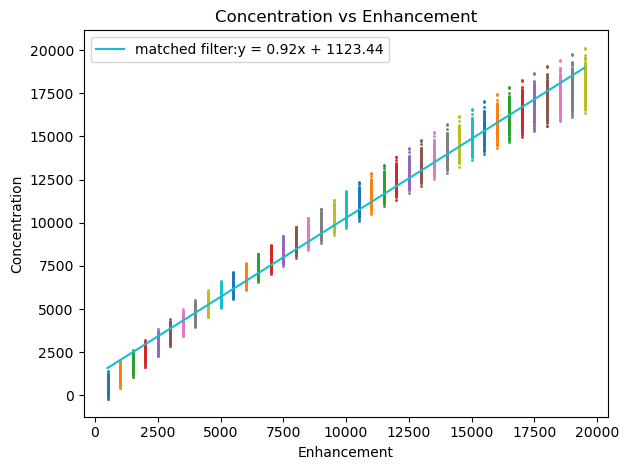

In [37]:
def imagelevel_test2_1():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    
    # 读取 AHSI 单位吸收谱
    uas_filepath = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_40000.txt"
    _,uas = nf.open_unit_absorption_spectrum(uas_filepath,2150,2500)
    
    # 读取背景光谱
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    resultlist = []
    fig,ax = plt.subplots()
    enhancements = np.arange(500,20000,500)
    for enhancement in enhancements:
        # 生成2%像素浓度增强的模拟影像
        simulated_image,enhanced_mask,unenhanced_mask = twoperc_enhancement(enhancement)
        
        # 使用匹配滤波算法计算浓度增强
        result = matched_filter_with_fixed_bg(base_radiance,simulated_image, uas)
        
        # 计算增强和未增强像素的平均浓度
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
    
    polyfit_plot(enhancements,resultlist,ax,"matched filter")
    
    ax.set_xlabel("Enhancement")
    ax.set_ylabel("Concentration")
    ax.set_title("Concentration vs Enhancement")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test2_1()

### 多层匹配滤波算法

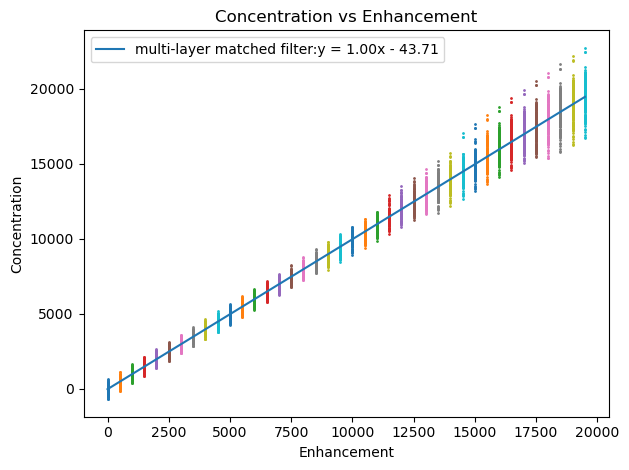

In [41]:
def imagelevel_test2_2():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用多层匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    
    # 读取 AHSI 单位吸收谱
    uaslist = []
    uasrange = np.arange(0,46000,4000)
    for i in uasrange:
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_{i}_{i+6000}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        uaslist.append(uas)
    
    # 读取背景光谱
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    fig,ax = plt.subplots()
    enhancements = np.arange(0,20000,500)
    resultlist = []
    for enhancement in enhancements:
        simulated_image,enhanced_mask,unenhanced_mask = twoperc_enhancement(enhancement)
        # 使用匹配滤波算法计算浓度增强
        result = modified_matched_filter_with_fixed_bg(base_radiance,simulated_image, uaslist)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    polyfit_plot(enhancements,resultlist,ax,"multi-layer matched filter")
    ax.set_xlabel("Enhancement")
    ax.set_ylabel("Concentration")
    ax.set_title("Concentration vs Enhancement")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return resultlist

resultlist = imagelevel_test2_2()


### 两种算法进行对比

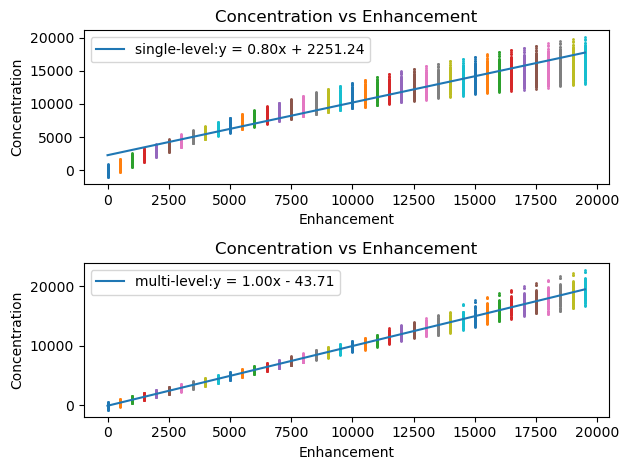

In [42]:
def imagelevel_test2_12():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    resultlist1 = []
    resultlist2 = []
    
    # 读取 AHSI 单位吸收谱
    uas_filepath = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_40000.txt"
    _,uas = nf.open_unit_absorption_spectrum(uas_filepath,2150,2500)
    
    uaslist = []
    uasrange = np.arange(0,46000,4000)
    for i in uasrange:
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_{i}_{i+6000}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        uaslist.append(uas)
    
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    fig,ax = plt.subplots(2,1)
    enhancements = np.arange(0,20000,500)
    for enhancement in enhancements:
        simulated_image,enhanced_mask,unenhanced_mask = twoperc_enhancement(enhancement)

        # 使用匹配滤波算法计算浓度增强
        result = matched_filter_with_fixed_bg(base_radiance,simulated_image, uas)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist1.append(np.mean(enhanced))
        ax[0].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        result = modified_matched_filter_with_fixed_bg(base_radiance,simulated_image, uaslist)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist2.append(np.mean(enhanced))
        ax[1].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    polyfit_plot(enhancements,resultlist1,ax[0],"single-level")
    ax[0].legend()
    
    polyfit_plot(enhancements,resultlist2,ax[1],"multi-level")
    ax[1].legend()
    
    ax[0].set_xlabel("Enhancement")
    ax[0].set_ylabel("Concentration")
    ax[0].set_title("Concentration vs Enhancement")
    ax[0].legend()
    
    ax[1].set_xlabel("Enhancement")
    ax[1].set_ylabel("Concentration")
    ax[1].set_title("Concentration vs Enhancement")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()
    return resultlist1,resultlist2

resultlist1,resultlist2 = imagelevel_test2_12()

## 模拟影像测试_2(背景光谱未知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱未知，需要近似和不断修正，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

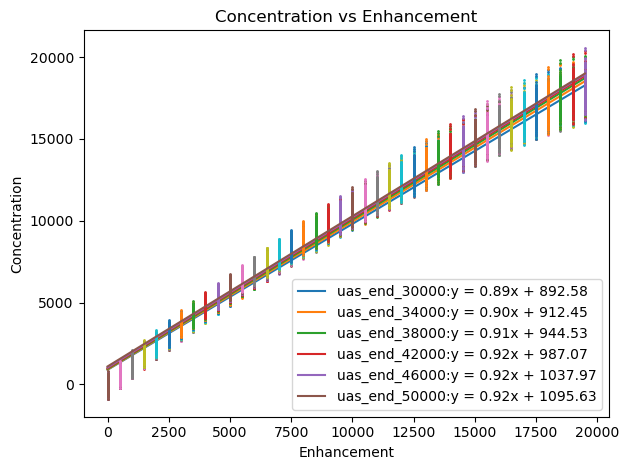

In [45]:
def imagelevel_test2_3():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    使用不同的单位吸收光谱
    """
    # 读取 AHSI 单位吸收谱
    fig,ax = plt.subplots()
    for end in range(30000,52000,4000):
        # 读取单位吸收光谱
        uas_filepath = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{end}.txt"
        _,uas = nf.open_unit_absorption_spectrum(uas_filepath,2150,2500)
        
        enhancements = np.arange(0,20000,500)
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = twoperc_enhancement(enhancement)
            result = mf.matched_filter(simulated_image, uas, iterate = False, albedoadjust=False, sparsity= False)
            
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            
            ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        polyfit_plot(enhancements,resultlist,ax,f"uas_end_{end}")
    
    ax.set_xlabel("Enhancement")
    ax.set_ylabel("Concentration")
    ax.set_title("matched filter")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    return resultlist
    
resultlist = imagelevel_test2_3()

### 多层匹配滤波算法

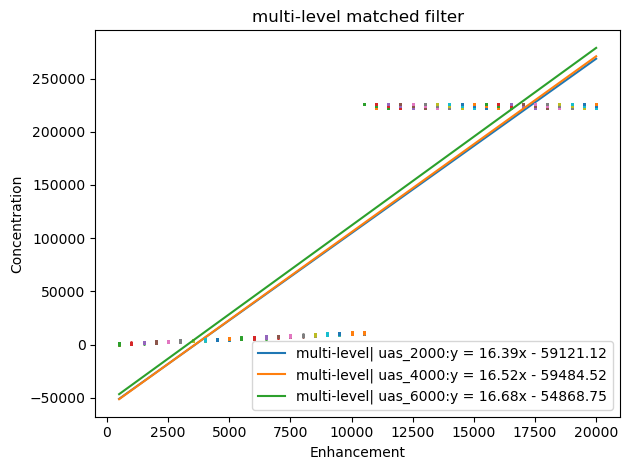

In [47]:
def imagelevel_test2_4():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    fig,ax = plt.subplots()
    for n in range(2000,8000,2000):
        # 读取单位吸收光谱列表
        uaslist = []
        uasrange = np.arange(n,46000,6000)
        np.insert(uasrange,0,0)
        for i in uasrange:
            _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
            uaslist.append(uas)
        
        enhancements = np.arange(500,20500,500)
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = twoperc_enhancement(enhancement)
            result,_ = mf.modified_matched_filter(simulated_image, uaslist)
            
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            
            ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        polyfit_plot(enhancements,resultlist,ax,f"multi-level| uas_{n}")
    ax.set_xlabel("Enhancement")
    ax.set_ylabel("Concentration")
    ax.set_title("multi-level matched filter")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    return resultlist
    
resultlist = imagelevel_test2_4()

### 两种算法对比

当前浓度增强为：0
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：1000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：1500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：2000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：2500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：3000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：3500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：4000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：4500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：5000
iteration: 

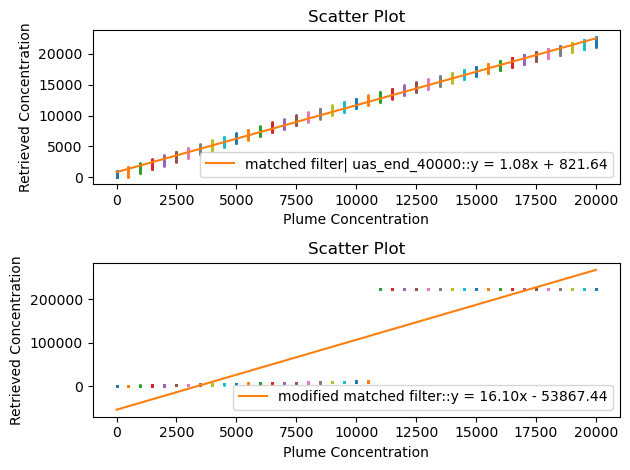

In [48]:
def imagelevel_test2_34():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强的反演结果
    背景光谱未知，使用多层的单位吸收光谱
    并拟合出浓度增强与实际浓度增强的关系，
    """
    uas_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_40000.txt"
    _,general_uas = nf.open_unit_absorption_spectrum(uas_path,2150,2500)
    
    uaslist = []
    uasrange = np.arange(4000,46000,6000)
    np.insert(uasrange,0,0)
    for i in uasrange:
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_{i}_{i+6000}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        uaslist.append(uas)
    
    fig,ax = plt.subplots(2,1)
    enhancements = np.arange(0,20500,500)
    resultlist = []
    resultlist2 = []
    for enhancement in enhancements:
        print("当前浓度增强为："+ str(enhancement))
        simulated_image,enhanced_mask,unenhanced_mask = twoperc_enhancement(enhancement)
        
        # 使用匹配滤波算法计算浓度增强
        result = mf.matched_filter(simulated_image, general_uas, iterate = True, albedoadjust=True, sparsity= False)
        enhanced = result[enhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax[0].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        result,_ = mf.modified_matched_filter(simulated_image, uaslist)
        enhanced = result[enhanced_mask]
        resultlist2.append(np.mean(enhanced))
        ax[1].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    # 创建一个新的 x 值数组用于绘制拟合直线
    polyfit_plot(enhancements,resultlist,ax[0],"matched filter| uas_end_40000:")
    
    polyfit_plot(enhancements,resultlist2,ax[1],"modified matched filter:")
    
    ax[0].set_xlabel('Plume Concentration')
    ax[0].set_ylabel('Retrieved Concentration')
    ax[0].set_title(f'Scatter Plot')
    ax[0].legend()
    
    ax[1].set_xlabel('Plume Concentration')
    ax[1].set_ylabel('Retrieved Concentration')
    ax[1].set_title(f'Scatter Plot')
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    return resultlist,resultlist2

resultlist1,resultlist2 = imagelevel_test2_34()

## 模拟影像测试_3
此测试针对 叠加了高斯烟羽甲烷浓度增强分布的模拟影像，背景光谱未知，需要通过近似和修正来贴近真实背景光谱
使用不同的匹配滤波算法进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

C:\Users\RS\AppData\Local\Temp\ipykernel_36536\3014382712.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(endpoints))


iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5


C:\Users\RS\AppData\Local\Temp\ipykernel_36536\3014382712.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(plume[total_mask],enhancement[total_mask],c= colors[idx],alpha=0.5)


iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5


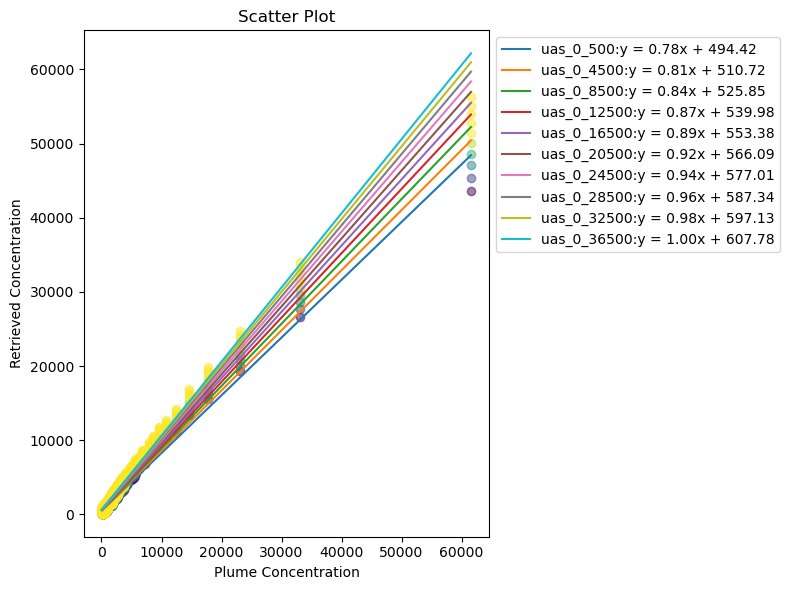

In [51]:
def imagelevel_test3_1():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    endpoints = np.arange(500, 40500, 4000 )
   
    # 设置色带
    colormap = cm.get_cmap('viridis', len(endpoints))
    norm_values = np.clip((endpoints - 0) / (20000 -0), 0, 1)
    colors = colormap(norm_values)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for idx, i in enumerate(endpoints):
        # 加载单位吸收谱并生成匹配滤波算法的结果
        _,uas = gu.generate_range_uas_AHSI(0,i,2150,2500)
        enhancement = mf.matched_filter(simulated_image, uas, iterate= True, albedoadjust=True, sparsity= False)
        
        plume_mask = plume > 100
        result_mask = enhancement > 100
        total_mask = plume_mask*result_mask
        
        # 可视化
        ax.scatter(plume[total_mask],enhancement[total_mask],c = colors[idx],alpha=0.5)
        polyfit_plot(plume[total_mask].flatten(),enhancement[total_mask].flatten(),ax,f"uas_0_{i}")
    
        # 对烟羽反演结果进行量化
        molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
        molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
        emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
        retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
        
    # 拟合原始增强和反演结果的关系   
    ax.set_xlabel('Plume Concentration')
    ax.set_ylabel('Retrieved Concentration')
    ax.set_title(f'Scatter Plot')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot
    
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_1()

### 多层匹配滤波算法

current threshold: 6000
current threshold: 12000
current threshold: 18000
current threshold: 24000
current threshold: 30000
current threshold: 36000
0.9806601492015411


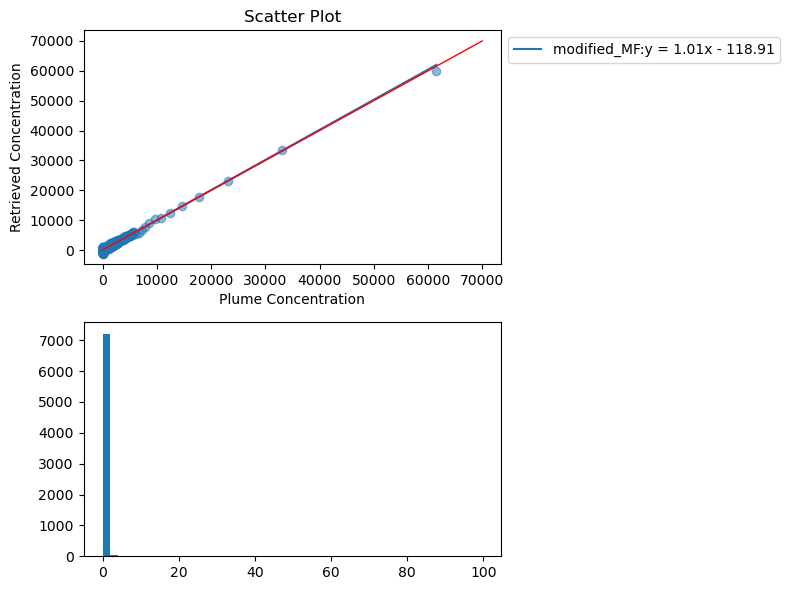

In [55]:
def imagelevel_test3_2():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽模型
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    # 读取单位吸收光谱列表
    uaslist = []
    uasrange = np.arange(4000,46000,6000)
    np.insert(uasrange,0,0)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)

    endpoints = np.arange(500, 20500, 4000)
    fig, ax = plt.subplots(2,1,figsize=(8, 6))
    # enhancement,_ = mf.modified_matched_filter(simulated_image, uaslist)
    enhancement,_ = mf.modified_matched_filter_backup(simulated_image, uaslist)
    
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask*result_mask
    
    nonplume_mask = plume < 100
    nonresult_mask = enhancement < 100
    bg_mask = nonplume_mask*nonresult_mask
    # 可视化
    ax[0].scatter(plume,enhancement,alpha=0.5)
    polyfit_plot(plume.flatten(),enhancement.flatten(),ax[0],"modified_MF")
    ax[1].hist(plume[bg_mask].flatten(), bins=50)
    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    print(emission/retrieval_emission)
    
    # 拟合原始增强和反演结果的关系   
    ax[0].plot([0, 70000], [0, 70000], color='red', linestyle='-', linewidth=1)
    ax[0].set_xlabel('Plume Concentration')
    ax[0].set_ylabel('Retrieved Concentration')
    ax[0].set_title(f'Scatter Plot')
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_2()

### 两种算法对比

current threshold: 6000
current threshold: 12000
current threshold: 18000
current threshold: 24000
current threshold: 30000
current threshold: 36000
0.9847795463758081


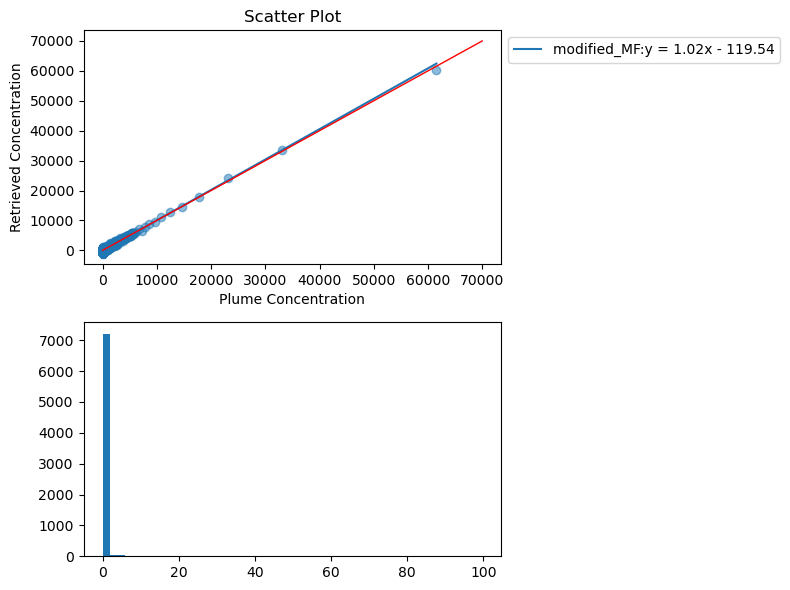

In [57]:
def imagelevel_test3_3():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽模型
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    # 读取单位吸收光谱列表
    uaslist = []
    uasrange = np.arange(4000,46000,6000)
    np.insert(uasrange,0,0)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)

    endpoints = np.arange(500, 20500, 4000)
    fig, ax = plt.subplots(2,1,figsize=(8, 6))
    # enhancement,_ = mf.modified_matched_filter(simulated_image, uaslist)
    enhancement,_ = mf.modified_matched_filter_backup(simulated_image, uaslist)
    
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask*result_mask
    
    nonplume_mask = plume < 100
    nonresult_mask = enhancement < 100
    bg_mask = nonplume_mask*nonresult_mask
    # 可视化
    ax[0].scatter(plume,enhancement,alpha=0.5)
    polyfit_plot(plume.flatten(),enhancement.flatten(),ax[0],"modified_MF")
    ax[1].hist(plume[bg_mask].flatten(), bins=50)
    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    print(emission/retrieval_emission)
    
    # 拟合原始增强和反演结果的关系   
    ax[0].plot([0, 70000], [0, 70000], color='red', linestyle='-', linewidth=1)
    ax[0].set_xlabel('Plume Concentration')
    ax[0].set_ylabel('Retrieved Concentration')
    ax[0].set_title(f'Scatter Plot')
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_3()